In [1]:
import copy
from PIL import Image
from glob import glob
from matplotlib import cm, image, patches, pyplot as plt
import io

import cv2
import numpy as np


In [9]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import time


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]+1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts+lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# Time Test
masks = pd.read_csv('/media/z/e9503728-f419-4a14-9fc0-21e2947af50c/DATA/car/train_masks.csv')
num_masks = masks.shape[0]
print('Total masks to encode/decode =', num_masks)

time_enc = 0.0  # seconds
time_dec = 0.0  # seconds

for r in masks.itertuples():
    t0 = time.perf_counter()
    mask = rle_decode(r.rle_mask, (1280, 1918))
    time_dec += time.perf_counter()-t0
    t0 = time.perf_counter()
    mask_rle = rle_encode(mask)
    time_enc += time.perf_counter()-t0  #assert (mask_rle == r.rle_mask)

print('Time full encoding = {:.4f} ms per mask'.format(1000*time_enc/num_masks))
print('Time full decoding = {:.4f} ms per mask'.format(1000*time_dec/num_masks))

Total masks to encode/decode = 5088
Time full encoding = 3.4204 ms per mask
Time full decoding = 0.4744 ms per mask


In [21]:
# cut raw img data into n*n array
# data_path = "/home/z/MVPC10/DATA/mvpc10/**/*.jpg"
# data_path = "/home/z/MVPC10/DATA/*.jpeg"
# data_path = "/media/z/e9503728-f419-4a14-9fc0-21e2947af50c/DOWNLOAD/301137.jpeg"
data_path = "/media/z/e9503728-f419-4a14-9fc0-21e2947af50c/DOWNLOAD/301137.jpeg"
data_rgb = "/media/z/e9503728-f419-4a14-9fc0-21e2947af50c/DOWNLOAD/301138.jpeg"

In [22]:
files = []
for file in glob(data_path):
    files.append(file)
print(len(files))

1


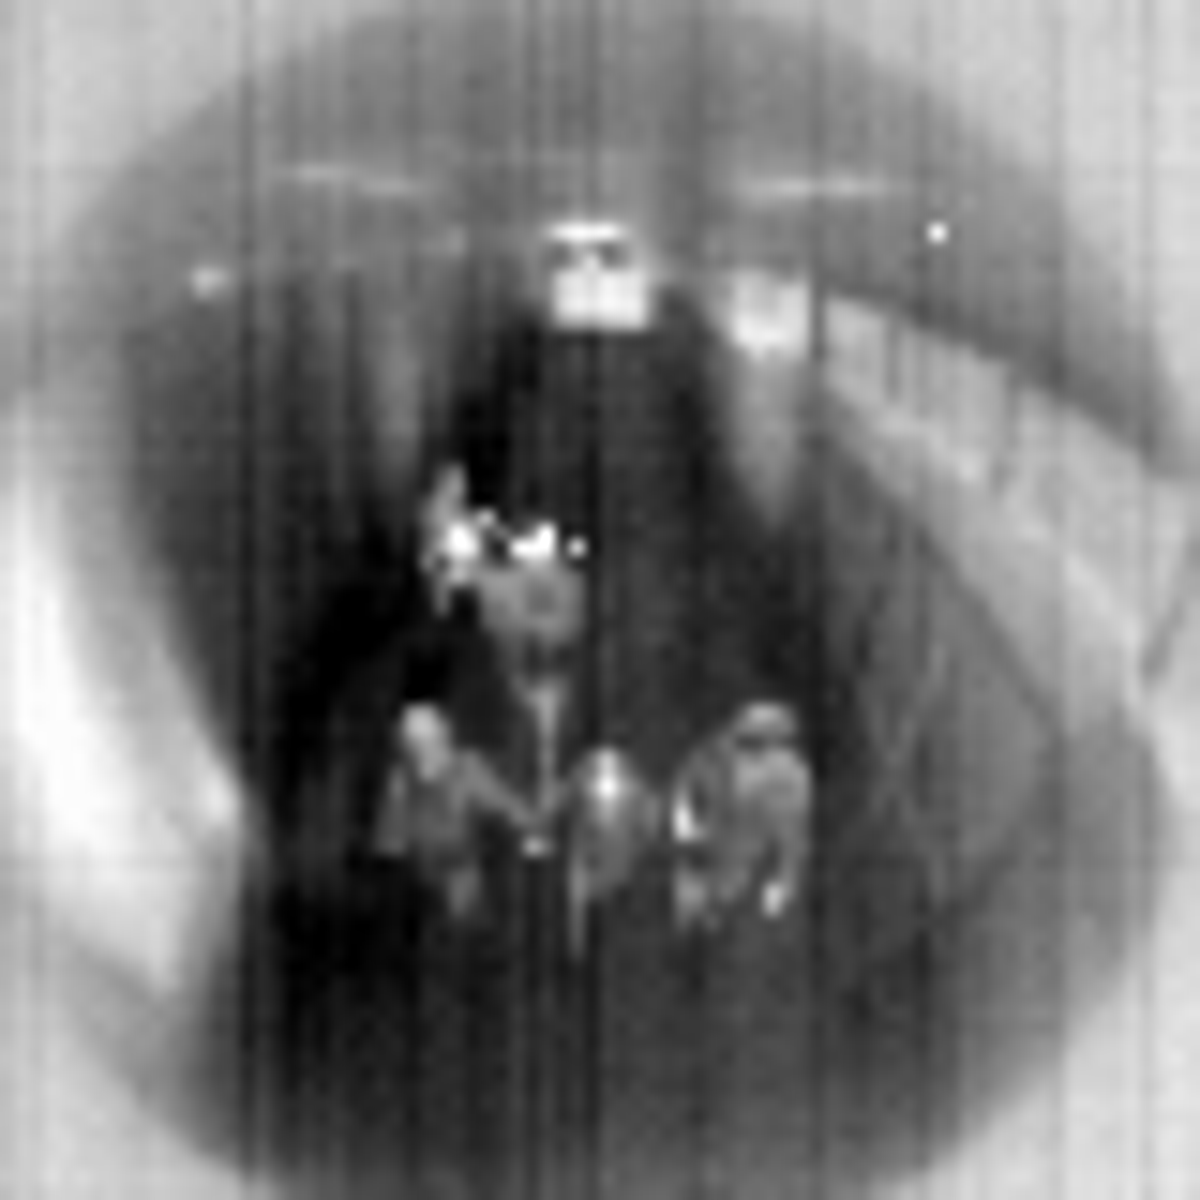

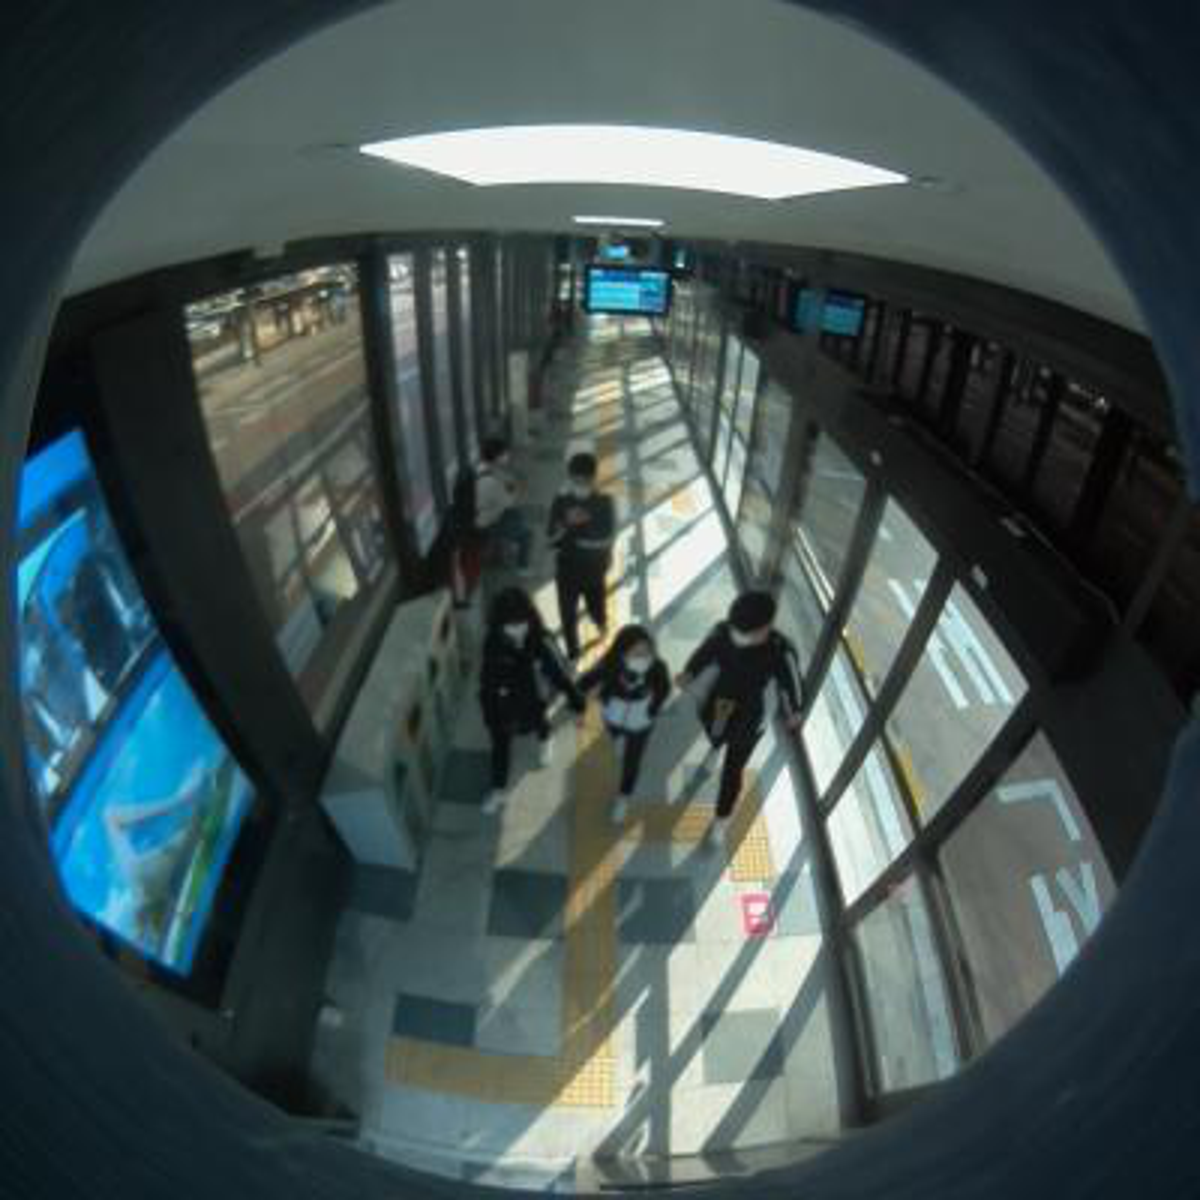

In [23]:
ir_img = Image.open(files[0]).convert('L')
# raw_img = Image.open(data_path).convert('L')

ir_resize = ir_img.resize([1200,1200])

display(ir_resize)

image_rgb = Image.open(data_rgb)#.convert('L')
rgb_resize = image_rgb.resize([1200,1200])
display(rgb_resize)

In [28]:
def overlayer(img1, img2):
    background = cv2.imread(img1)
    background = cv2.resize(background, dsize=(1200, 1200))

    foreground = cv2.imread(img2)
    foreground = cv2.resize(foreground, dsize=(1200, 1200))

    alpha = 1.0
    while True:
        overlayed = cv2.addWeighted(src1=background, alpha=alpha, src2=foreground, beta=1-alpha, gamma=0)

        cv2.putText(overlayed, f'alpha: {alpha:.2f}', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,255), thickness=2,) # lineType=cv2.LINE_AA)

        cv2.imshow("overlayed", overlayed)

        key = cv2.waitKey()
        # print(key)
        if key == 81:
            alpha -= 0.02
            if alpha < 0: alpha = 0
        elif key == 83:
            alpha += 0.02
            if alpha > 1: alpha = 1
        elif key == 27:
            cv2.destroyAllWindows()
            break


In [29]:
overlayer(data_path, data_rgb)

In [10]:
img_arr = np.array(ir_img)
w, h = img_arr.shape
print(w, h)
# for i in img_arr:
#     print(i)
print(img_arr[0])
print(img_arr[79])


80 80
[165 177 193 219 190 184 179 206 179 173 188 183 169 170 202 205 172 180
 175 173 205 163 171 156 153 171 168 154 138 137 140 132 141 146 129 127
 139 164 132 129 146 130 166 155 127 129 129 151 151 159 154 188 176 180
 187 205 164 175 201 203 213 213 201 218 222 194 197 201 208 201 200 208
 243 211 199 220 222 207 211 211]
[178 184 203 229 192 195 184 218 187 173 190 187 173 165 198 204 150 145
 124 119 149  90  93  85  90 127 129 128  98 110 116 108 117 133 114 118
 122 157 105 102 114 119 145 148 117 115 111 125 132 138 131 169 159 165
 180 212 176 180 215 214 220 218 208 232 239 204 211 214 218 212 207 221
 253 228 221 238 243 224 224 234]


In [55]:
def normalize(img, min=0, max=255, w=80, h=80):
    """
    :return: normalize img from min to max and reshape to w, h
    """
    norm = np.array([])
    for i in img:
        norm = np.append(norm, (i/max), axis=0).astype(np.float16)
    norm = np.reshape(norm, (w, h))
    return norm

In [56]:
def add_channel(img):
    # img = np.expand_dims(img_arr, axis=-1)
    # img = img_arr.reshape(img_arr.shape[0], img_arr.shape[1], 1)
    reshaped_img = img.reshape(img.shape[0], img.shape[1], 1)
    return reshaped_img

In [57]:
def loop_tiler(img, t_w, t_h, dtype):
    w1, h1 = w//t_w, h//t_h
    tile = np.zeros((h1, w1, t_h, t_w)).astype(dtype)
    y = x = 0
    for i in range(0, h, t_h):
        for j in range(0, w, t_w):
            tile[y][x] = img[i:i+t_h, j:j+t_w]
            x += 1
        y += 1
        x = 0
    return tile, w1, h1

In [58]:
def reshape_tiler(img, t_w, t_h):
    w1, h1 = w//t_w, h//t_h
    tile = img.reshape(h1, t_h, w1, t_w)
    tile = tile.swapaxes(1, 2)
    return tile, w1, h1

In [59]:
def cutoff_filter(img, min, max, nmin, nmax):
    li = []
    for i in img:
        for j in i:
            if j < min: j = nmin
            if j > max: j = nmin
            li.append(j)

    return li


In [14]:
def tiler(img, t_w, t_h):
    tile, rows, columns = loop_tiler(img, t_w, t_h)
    tli = []
    n, m = 0, 0
    for i in range(rows*columns):
        t = tile[n,m]
        m += 1
        if m == rows:
            n += 1
            m = 0
        if n == columns: n = 0
        tli.append(t)
    return tli

In [15]:
# 80    2 2 2 2 5    2 4 6 8 16   20 40
def tile_plotter(img, t_w=80, t_h=80, min=0, max=255, dtype=int, color=cm.magma):
    tile, rows, columns = loop_tiler(img, t_w, t_h, dtype)
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=[20,20])
    n, m = 0, 0
    grid = rows*columns
    if grid==1: plt.imshow(tile[n,m], cmap=color, vmin=min, vmax=max,)
    else:
        for i in range(grid):
            ax[n,m].axis('off')
            ax[n,m].imshow(tile[n,m], cmap=color, vmin=min, vmax=max,)
            m += 1
            if m == rows:
                n += 1
                m = 0
            if n == columns: n = 0

    return plt

In [16]:
img = cutoff_filter(img_arr, 63, 207, 0, 255)
img = np.reshape(img, (80,80))
print(img.shape)
for i in img[35:45]:
    print(i)

(80, 80)
[  0   0   0 207 185 170 158 150 129 109  88  69  63   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  85 151   0 188  94 105  80 139
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  64   0  64
   0  79  93  97 106  87 105 100 137 149 171 175 183 189 203 200 182 191
 184 191 184 193 183 200 201 172]
[  0   0   0   0 190 168 164 154 134 115  87  64   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  93 169   0   0  78   0   0   0
   0  76 193   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  76  81  91  94  78 106  87 116 144 162 163 174 180 181 188 187 193
 183 182 181 191 177 193 189 156]
[  0   0   0   0 195 169 157 154 144 117 100  75   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 111  85 177 155 100  73 132 187
 171  98   0   0   0   0  66   0   0   0   0   0   0   0   0   0   0   0
   0  74  83  87  90  91 106  99 102 126 162 161 168 177 182 180 180   0
 196 187 184 189 179 198 183 158]
[  0   0   0 

In [17]:
reshaped_img = add_channel(img_arr)
w, h, c = reshaped_img.shape
print(w, h, c)
print(reshaped_img[:4,:4,:])

80 80 1
[[[182]
  [196]
  [195]
  [203]]

 [[181]
  [197]
  [195]
  [210]]

 [[189]
  [199]
  [195]
  [206]]

 [[191]
  [200]
  [191]
  [209]]]


In [18]:
normed_img = normalize(img_arr, 0, 255, w, h)
print(normed_img.shape)
# for i in normed_img:
#     print(i)
print(normed_img[0])
print(normed_img[79])


(80, 80)
[0.714  0.7686 0.7646 0.796  0.792  0.788  0.7803 0.7725 0.749  0.757
 0.7803 0.7686 0.7725 0.7607 0.757  0.7764 0.698  0.788  0.753  0.718
 0.7295 0.7295 0.7373 0.6943 0.6904 0.6704 0.639  0.5845 0.612  0.596
 0.596  0.5566 0.545  0.5527 0.604  0.5215 0.596  0.545  0.5605 0.502
 0.596  0.5527 0.6    0.5845 0.569  0.5605 0.533  0.5923 0.604  0.6665
 0.6743 0.706  0.7217 0.7256 0.6904 0.7373 0.7295 0.7334 0.784  0.7764
 0.7686 0.749  0.784  0.7686 0.82   0.8    0.816  0.796  0.82   0.7764
 0.7803 0.8354 0.8276 0.8276 0.7803 0.8315 0.753  0.8315 0.855  0.8037]
[0.749  0.8    0.7803 0.8315 0.8237 0.8237 0.796  0.8115 0.7803 0.7725
 0.792  0.784  0.7686 0.749  0.7334 0.7217 0.612  0.608  0.502  0.4119
 0.3882 0.3372 0.341  0.2903 0.2903 0.2864 0.2666 0.2393 0.2432 0.2744
 0.298  0.2471 0.2235 0.2744 0.302  0.2471 0.341  0.306  0.3254 0.2825
 0.3647 0.3647 0.3882 0.4    0.4    0.357  0.3176 0.3687 0.3687 0.4275
 0.4275 0.4392 0.4119 0.4314 0.396  0.4666 0.498  0.498  0.5923 0.643
 

In [19]:
tile, rows, columns = loop_tiler(normed_img, 8, 8, np.float16)
print(tile.shape)
# for i, j in enumerate(tile):
#     print(i, j)
tile[9,9]

(10, 10, 8, 8)


array([[0.8315, 0.8315, 0.8237, 0.855 , 0.792 , 0.847 , 0.902 , 0.8784],
       [0.8706, 0.851 , 0.851 , 0.8745, 0.82  , 0.8823, 0.898 , 0.89  ],
       [0.847 , 0.863 , 0.8433, 0.863 , 0.82  , 0.859 , 0.8706, 0.8667],
       [0.863 , 0.8276, 0.8237, 0.863 , 0.8237, 0.8823, 0.902 , 0.8706],
       [0.855 , 0.8394, 0.8354, 0.8667, 0.8   , 0.89  , 0.89  , 0.8667],
       [0.859 , 0.863 , 0.8433, 0.8667, 0.8037, 0.8745, 0.886 , 0.859 ],
       [0.8706, 0.8745, 0.8667, 0.886 , 0.8354, 0.886 , 0.9097, 0.8745],
       [0.8706, 0.8784, 0.847 , 0.894 , 0.8037, 0.8706, 0.898 , 0.847 ]],
      dtype=float16)

In [20]:
# tile, rows, columns = loop_tiler(img_arr, 8, 8, int)
# print(tile.shape)
# for i, j in enumerate(tile):
#     print(i, j)
# tile[0,0]


In [21]:
low_cut = 91
high_cut = 300

min = 0
max = 255

n_min = 0
n_max = 1

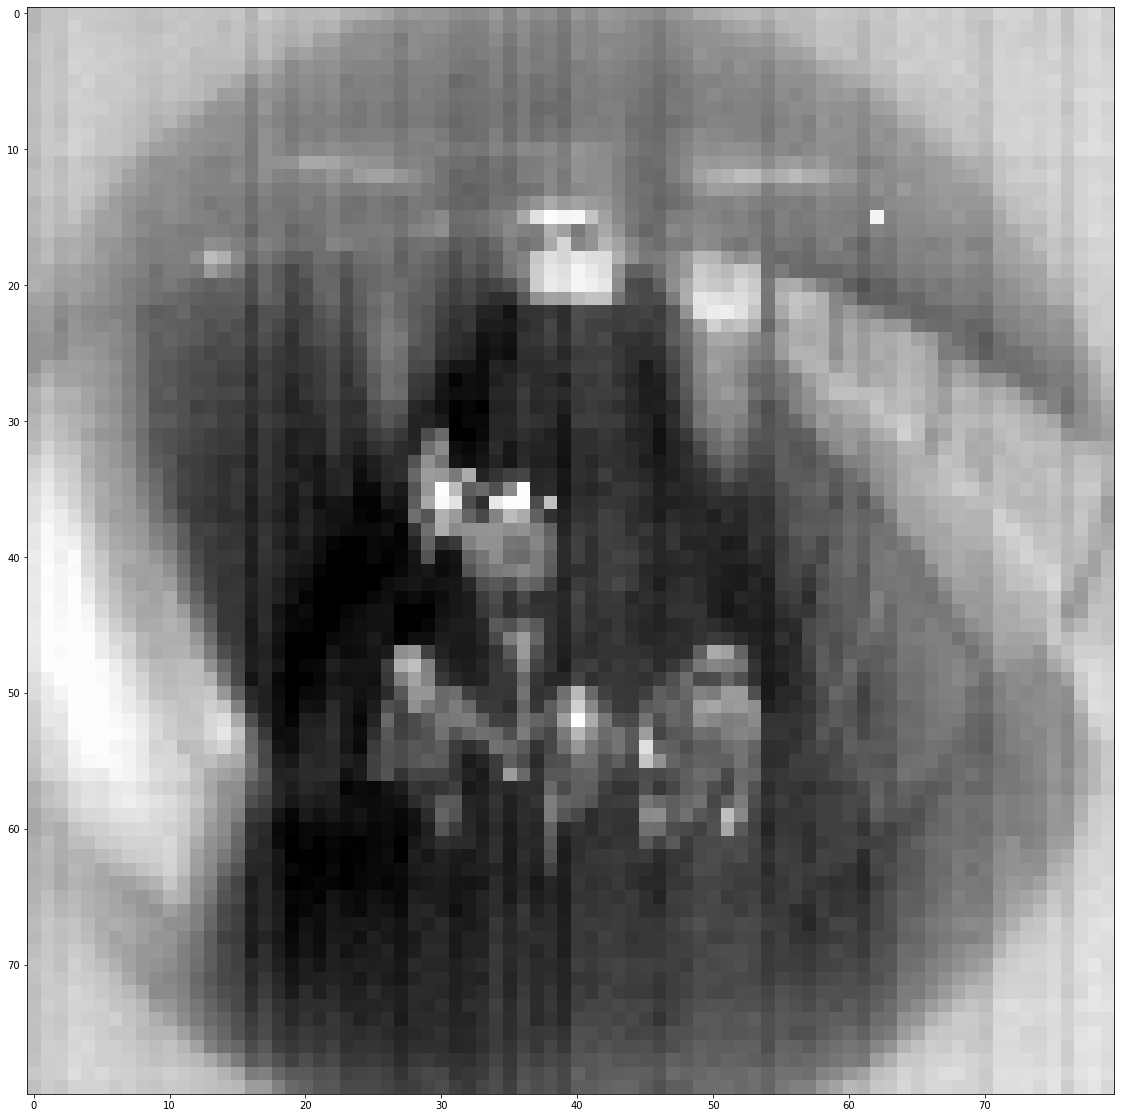

In [22]:
plot = tile_plotter(normed_img, 80, 80, 0, 1, float, cm.gray)
plot.show()

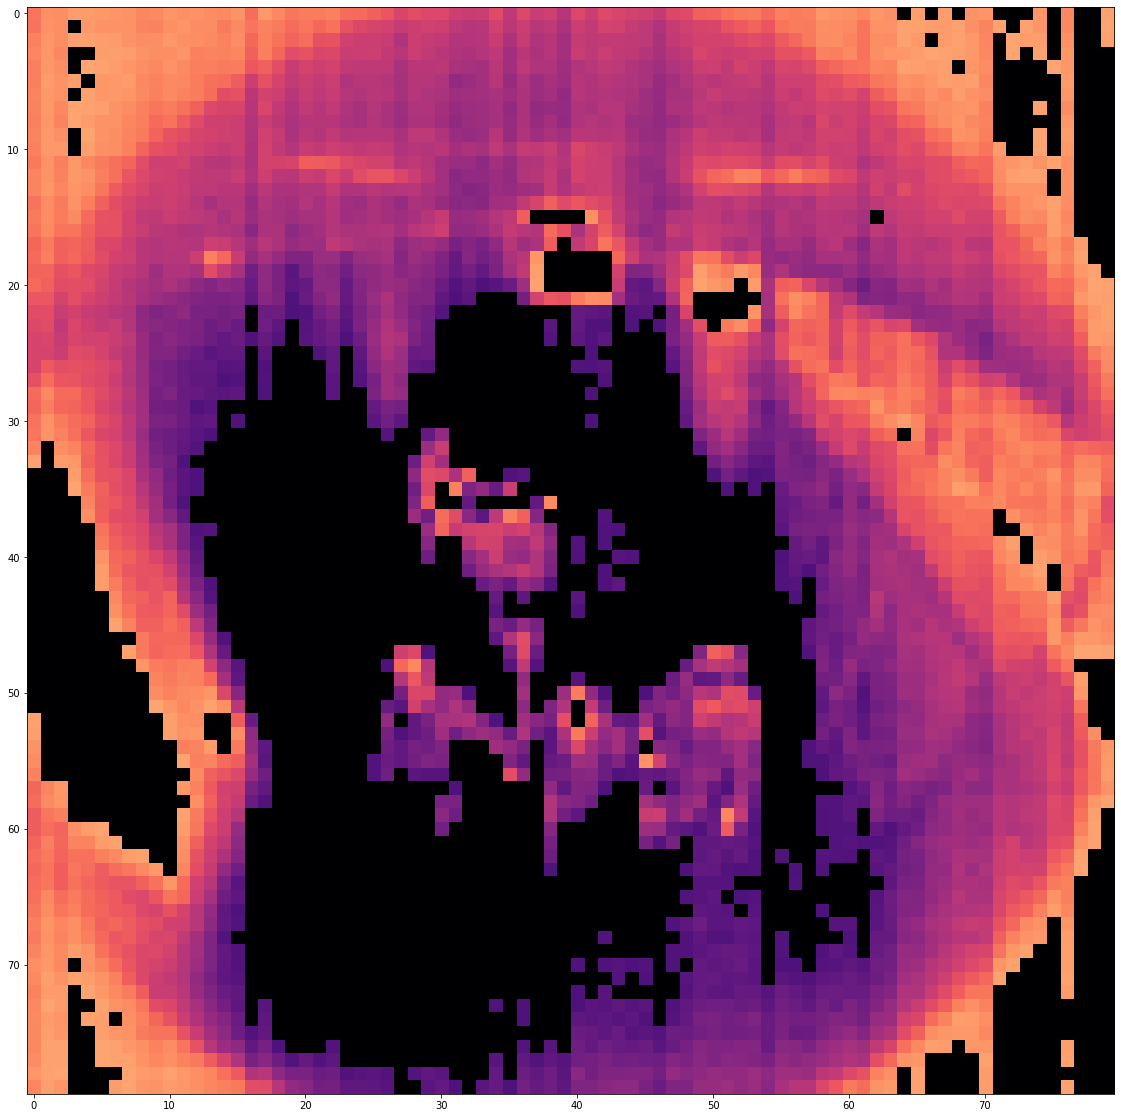

In [23]:
  plot = tile_plotter(img, 80, 80, min, max, int)
plot.show()

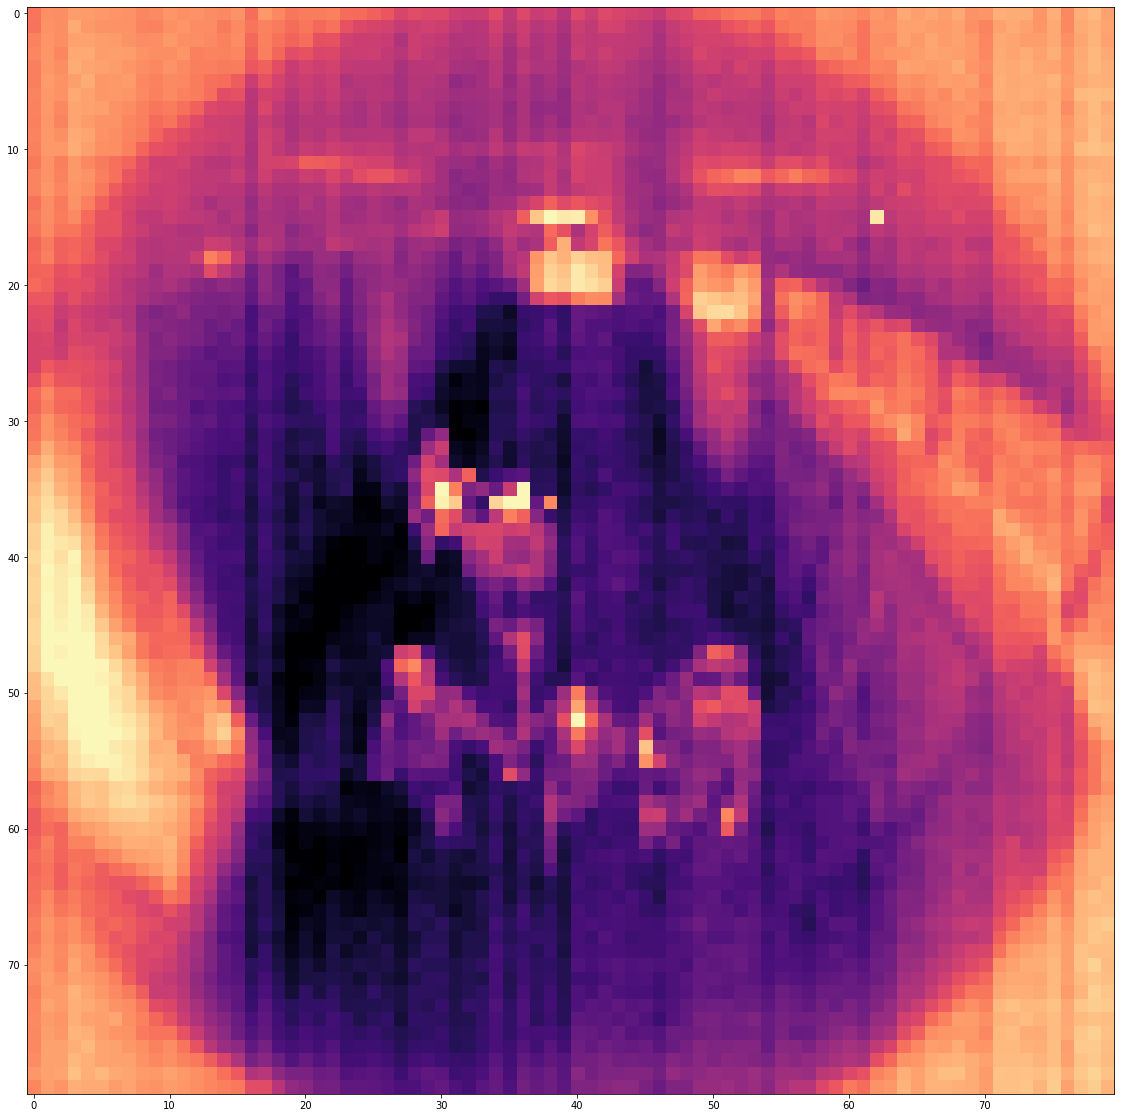

In [24]:
plot = tile_plotter(img_arr, 80, 80, min, max, int)
plot.show()

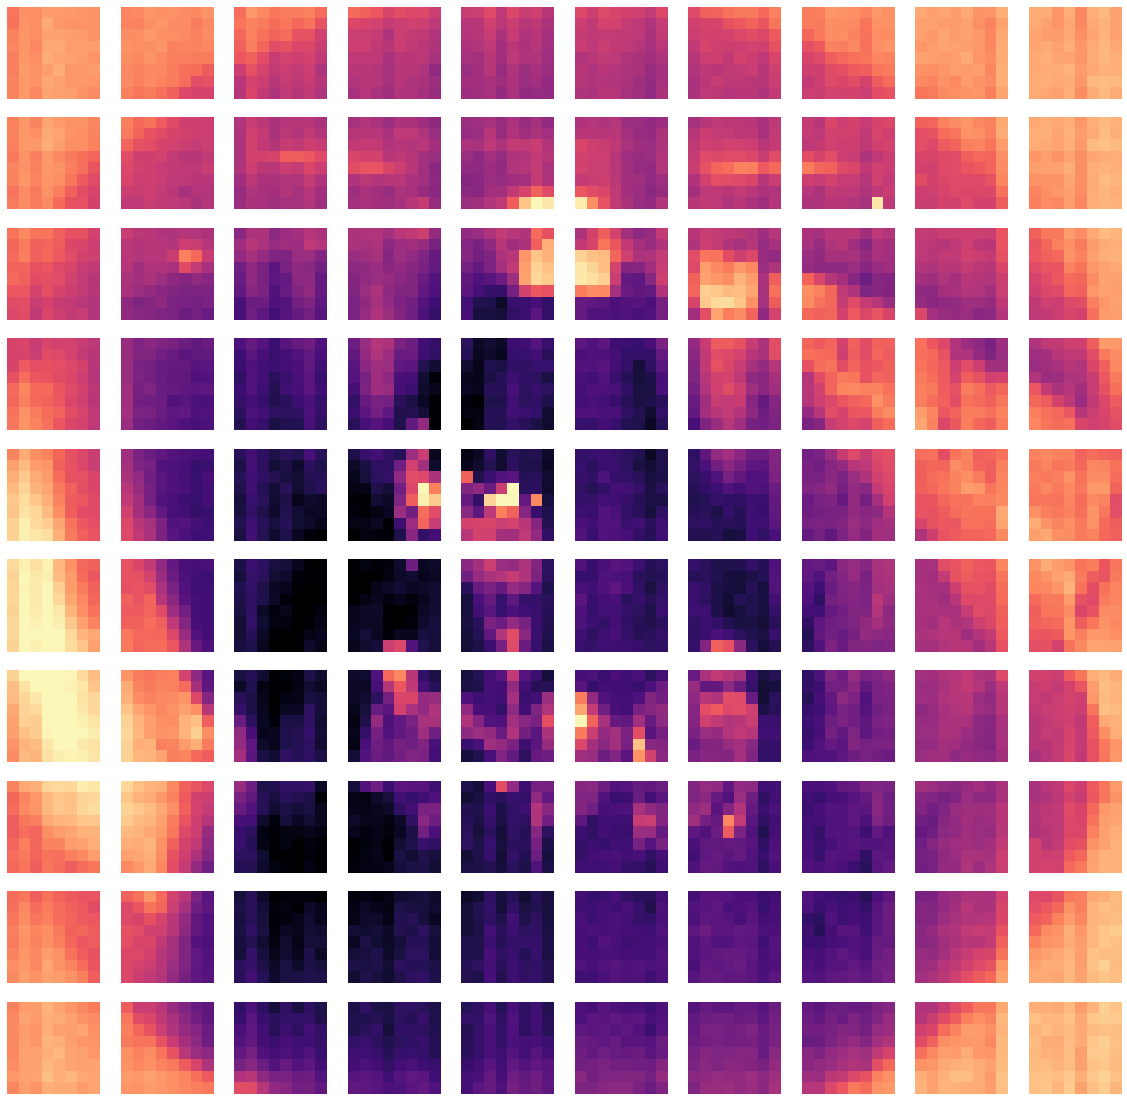

In [25]:
plot = tile_plotter(img_arr, 8, 8, min, max, int)
plot.show()

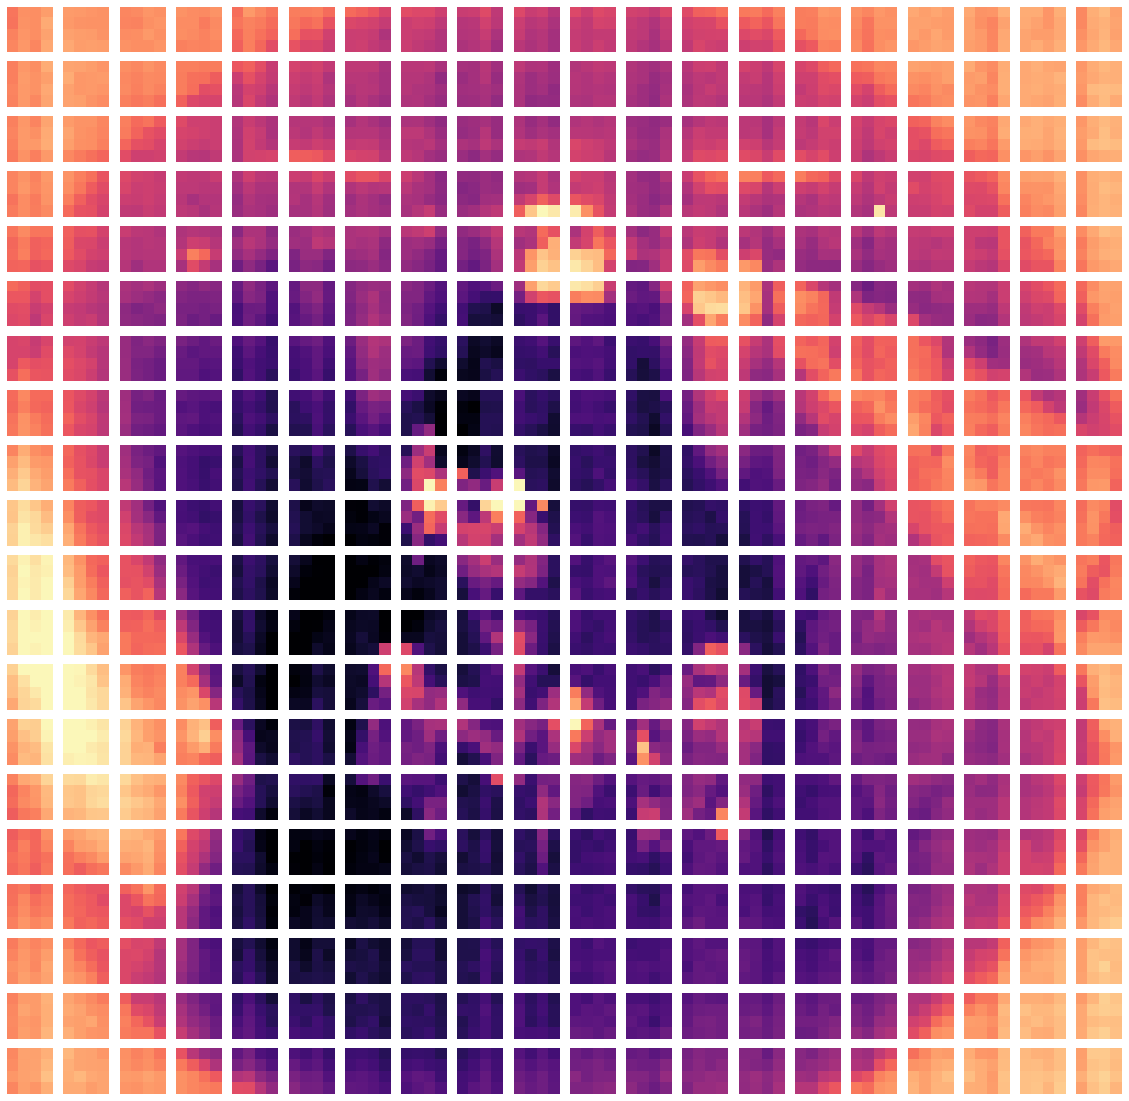

In [26]:
plot = tile_plotter(img_arr, 4, 4, min, max, int)
plot.show()

In [33]:
img_arr1 = copy.deepcopy(img_arr)
print(img_arr1)

cx = 39.
cy = 39.
r = 40.

img_arr1[(x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2] = 0.

plt.figure(figsize=(20,20))
plt.pcolormesh(x, y, img_arr1)
# plt.colorbar()
plt.show()

[[182 196 195 ... 212 218 205]
 [181 197 195 ... 210 214 207]
 [189 199 195 ... 208 215 205]
 ...
 [194 205 206 ... 223 226 219]
 [200 205 207 ... 226 232 223]
 [191 204 199 ... 222 229 216]]


TypeError: 'int' object is not subscriptable

In [ ]:
plt.figure(figsize=(20,20))
plt.pcolormesh(y, x, img_arr)
# plt.colorbar()
plt.show()

In [92]:
img = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
# img = img_arr1

scale = 20
width = int(img.shape[1] * scale)
height = int(img.shape[0] * scale)

img = cv2.resize(img, (width,height), interpolation=cv2.INTER_AREA)

img_blur = cv2.GaussianBlur(img, (3,3), 0)

edges = cv2.Canny(image=img, threshold1=100, threshold2=200)
e = Image.fromarray(edges, mode='L')
e.show()

# plt = tile_plotter(edges, color=cm.gray)
# plt.show()

# img_arr1 = copy.deepcopy(edges)
#
# r = 45
# center_x, center_y = 55, 39
# # mask = np.array([])
# mask = []
# for x, i in enumerate(edges):
#     for y, j in enumerate(i):
#         disstance = abs(center_x-x)+abs(center_y-y)
#         # print(x, y, disstance)
#         if disstance > r:
#             # mask = np.append(mask, (x,y))
#             mask.append([x,y])
# side cut
side = 15
img_arr1[:,:side] = 0
img_arr1[:,w-side:] = 0

#  top cut
img_arr1[:20,:] = 0

# distance cut
for i in mask:
    img_arr1[i[0],i[1]] = 0

# plt = tile_plotter(img_arr1, color=cm.gray)
# plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()

background = Image.fromarray(img, mode='L')
foreground = Image.fromarray(edges, mode='L')


background.paste(foreground, (0, 0), foreground)
background.show()



In [ ]:
tile, w1, h1 = loop_tiler(2,2)
print(w1, h1)
print(len(tile))

In [ ]:
tli = tiler(2,2)
len(tli)

In [ ]:
'''
every layer is a magnification
find different aspects in layers
sliding window to detect
'''

In [ ]:
'''
[training layers]

<0. pre_filter (0-1 low cut filter)>
if val < 128:    val = 0

<1. turn off layer>
16x16  -  confidence
8 x 8  -  confidence
4 x 4  -  confidence
2 x 2  -  confidence
1 x 1  -  segment

<2. CNN layer>
16x16  -  confidence
8 x 8  -  confidence
4 x 4  -  confidence
2 x 2  -  confidence
1 x 1  -  segment


'''

In [ ]:
'''
[input]

1. previous data = Null: [-1], None: [0], else: [[x1_c, y1_c, d1, d2, a], [x2_c, y2_c, d1, d2, a], ... ]
2. now data : 80 x 80


'''

In [ ]:
'''
[output] - detect, localization

Null: [-1], None: [0], else: [[x1_c, y1_c, d1, d2, a], [x2_c, y2_c, d1, d2, a], ... ] = input_1


'''

In [ ]:
'''
[fundamentals]
1. ROI : track heat blob over (191, 2x2)
2. classify
3. bounding box : find most accurate bbox
'''

In [ ]:
'''
1. rnn base (detection from time base)
2.
3. 16x16 grid = binary classification
4. from active 1, 8x8 grid softmax, 0 < threshold < 1 = classification
5. from active 2, 4x4 grid softmax, 0 < threshold < 1 = classification
6. from active 3, 2x2 grid softmax, 0 < threshold < 1 = segmentation

7. average surrounding
8. segment finder
9.

'''

In [ ]:
'''
[rcnn]
remember
1. compare with previous. give more weight if detected in the past
2. make 0 if not moving

'''

In [ ]:
'''
masking filter

low-cut filter
not-moving detecting filter



1. find all heat
2. compare with previous heat
    if sane: not ppl
    if different in same area: ppl
3. moving = ppl, else: background

'''

In [ ]:
'''
model input: 2 timeline(now, prev) data

model auto train: rgb model location to ir location

model ouput: now data ppl location
'''

In [ ]:
rgb_file = "/media/z/e9503728-f419-4a14-9fc0-21e2947af50c/DOWNLOAD/297162.jpeg"
# rgb_file1 = "/home/z/MVPC10/DATA/test/1.jpeg"

print(f"[I] cut rgb file")
rgb_img = Image.open(rgb_file)
rgb_arr = np.asarray(rgb_img, dtype='uint8')
h_rgb, w_rgb, c = rgb_arr.shape
w_cut, h_cut = 160, 40
rgb_arr = rgb_arr[h_cut:h_rgb-h_cut, w_cut:w_rgb-w_cut, :]
im = Image.fromarray(rgb_arr)
im.save(rgb_file)

In [ ]:
'''
1 layer : array layer

'''

In [ ]:
'''
1. overlayir, img
2. label img model1
3. train ir from model1 output
'''

In [ ]:
'''
pixel classification model auto learn on rgb model


'''